In [ ]:
"""
a simple GAN to generate MNIST digits
"""

In [1]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
from torchvision.datasets import MNIST
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [8]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
RANDOM_SEED = 42
LR = 0.0002

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 1

In [ ]:
# define transformation function for MNIST dataset

custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),                   # converts the input PIL image to the range (0,1)
    torchvision.transforms.Normalize(0.5, 0.5)           # centers the data around 0
])
train_data = MNIST(root=".", train=True, transform=custom_transforms, download=True)

In [5]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
class GAN(nn.Module):
  def __init__(self, latent_dim=100, image_height=28, image_width=28, color_channels=1):
    super().__init__()
    self.image_height = image_height
    self.image_width = image_width
    self.color_channels = color_channels

    self.generator = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.LeakyReLU(inplace=True),
        nn.Linear(128, self.image_height*self.image_width*self.color_channels),
        nn.Tanh()
    )

    self.discriminator = nn.Sequential(
        nn.Flatten(),
        nn.Linear(self.image_height*self.image_width*self.color_channels, 128),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Linear(128, 1)
    )

  def generator_forward(self, z):    # z shape NCHW
    z = torch.flatten(z, start_dim=1)
    img = self.generator(z)
    img = img.view(z.size(0),
                    self.color_channels,
                    self.image_height,
                    self.image_width)
    return img

  def discriminator_forward(self, img):
    logits = self.discriminator(img)
    return logits

In [7]:
model = GAN()

optim_gen = torch.optim.Adam(model.generator.parameters(), lr=LR)
optim_disc = torch.optim.Adam(model.discriminator.parameters(), lr=LR)

In [9]:
def train_GAN(latent_dim, num_epochs, model):
  loss_fn = nn.functional.binary_cross_entropy_with_logits
  fixed_noise = torch.randn(64, latent_dim, 1, 1)            # to check the loss at a specific interval
  for epoch in range(num_epochs):
    generator_loss, discrimnator_loss = 0, 0
    model.train()
    for batch_idx, (features, _) in enumerate(train_loader):
      batch_size = features.size(0)

      # real images
      real_labels = torch.ones(batch_size)

      # generated (fake) images
      noise = torch.randn(batch_size, latent_dim, 1, 1)
      fake_images = model.generator_forward(noise)
      fake_labels = torch.zeros(batch_size)
      flipped_fake_labels = real_labels

      # ------------ train the discriminator --------------
      optim_disc.zero_grad()
      # loss on real images
      disc_pred_real = model.discriminator_forward(features).view(-1)    # (N,1) --> N since target tensor is of shape N
      real_loss = loss_fn(disc_pred_real, real_labels)
      # loss on fake images
      disc_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
      fake_loss = loss_fn(disc_pred_fake, fake_labels)

      disc_loss = 0.5*(real_loss + fake_loss)
      discrimnator_loss += disc_loss.item()
      disc_loss.backward()
      optim_disc.step()

      # ------------ train the generator ------------------
      optim_gen.zero_grad()
      disc_pred_fake = model.discriminator_forward(fake_images).view(-1)
      gen_loss = loss_fn(disc_pred_fake, flipped_fake_labels)
      generator_loss += gen_loss.item()
      gen_loss.backward()
      optim_gen.step()
    generator_loss = generator_loss/batch_idx
    discrimnator_loss = discrimnator_loss/batch_idx
    print(f"Epoch:{epoch} ---- gen loss: {generator_loss},   disc loss: {discrimnator_loss}")

In [10]:
train_GAN(latent_dim=100, num_epochs=NUM_EPOCHS, model=model)

Epoch:0 ---- gen loss: 0.941706225148633,   disc loss: 0.38265310861488694
Epoch:1 ---- gen loss: 0.7429623640118501,   disc loss: 0.5287424415732042
Epoch:2 ---- gen loss: 0.7694319960398551,   disc loss: 0.5651220560838015
Epoch:3 ---- gen loss: 0.805778906513483,   disc loss: 0.5387698240641855
Epoch:4 ---- gen loss: 1.1574291732066717,   disc loss: 0.397198570971815
Epoch:5 ---- gen loss: 1.1702998387507904,   disc loss: 0.42810999299598557
Epoch:6 ---- gen loss: 1.0538103836469161,   disc loss: 0.45385912258146155
Epoch:7 ---- gen loss: 1.058269139411103,   disc loss: 0.47476387781719875
Epoch:8 ---- gen loss: 1.0346557908078544,   disc loss: 0.4772258771535678
Epoch:9 ---- gen loss: 1.072624815070731,   disc loss: 0.47628803602141195
Epoch:10 ---- gen loss: 1.1291066425987797,   disc loss: 0.47709459747768873


KeyboardInterrupt: 

In [11]:
model.eval()

# generating images from the trained generator
fixed_noise = torch.randn(64, 100, 1, 1)
generated_image = model.generator_forward(fixed_noise)

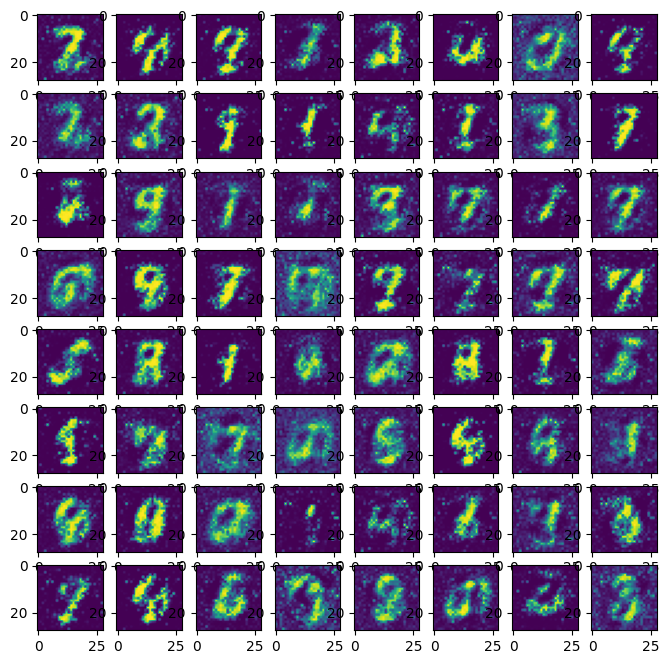

In [12]:
img_array = np.array(generated_image.detach())
plt.figure(figsize=(8,8))
for i in range(64):
  plt.subplot(8,8,i+1), plt.imshow(img_array[i][0])